In [5]:
#Импорт библиотек

import torch
from torch import nn
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import torch.nn as nn
from tqdm.notebook import tqdm
import cv2
import pandas as pd
import albumentations as A

In [6]:
#Основные пути

from pathlib import Path

ROOT = Path("dataset-here") #Указать путь до данных

train_image_path = ROOT / "train/images/"
train_mask_path = ROOT / "train/mask/"
test_image_path = ROOT / "test/images/"

In [7]:
#Загрузка датафреймов

df_data = pd.read_csv('../data/train_valid_holdt.csv')
train_df = df_data[df_data['stage'] == 'train']
valid_df = df_data[df_data['stage'] == 'valid']
holdt_df = df_data[df_data['stage'] == 'holdt']

print(train_df.shape, valid_df.shape, holdt_df.shape)

(6765, 2) (720, 2) (718, 2)


In [8]:
#Класс датасета

import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class NiiasDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.images_folder = train_image_path
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        name = self.df.iloc[index]['img_name']
        image = np.array(Image.open(os.path.join(self.images_folder, name)).convert("RGB"))
        mask_path = os.path.join(train_mask_path, name)   
        mask = np.array(Image.open(mask_path).convert("L"))
            
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
            
        image = image.transpose(2, 0, 1)
        image = torch.from_numpy(image)
        image = image.float()/255
            
        single_channels_mask = mask.copy()
        single_channels_mask[single_channels_mask == 6] = 1
        single_channels_mask[single_channels_mask == 7] = 2
        single_channels_mask[single_channels_mask == 10] = 3
        single_channels_mask = torch.from_numpy(single_channels_mask)

        multy_channels_mask = np.array([(mask == v) for v in [0, 6, 7, 10]])
        multy_channels_mask = np.stack(multy_channels_mask, axis=-1).astype('float')

        multy_channels_mask = multy_channels_mask.transpose(2, 0, 1)
        multy_channels_mask = torch.from_numpy(multy_channels_mask).float()

        return {
            'image': image,
            'single_mask': single_channels_mask,
            'multy_mask': multy_channels_mask,
        }


In [9]:
#Лоадеры

def get_loaders(
    train_df,
    valid_df,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = NiiasDataset(
        df=train_df,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = NiiasDataset(
        df=valid_df,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

In [10]:
#Необходимые параметры обучения

GLOBAL_PARAMETERS = {
    'LEARNING_RATE': 1e-3,
    'BATCH_SIZE': 32, 
    'NUM_EPOCHS': 150,
    'IMAGE_HEIGHT': 512,
    'IMAGE_WIDTH': 1024,
    'MODEL_NAME': 'unet-resnet34.pt',
    'LOSS': 'CrossEntropy',
    'NUM_WORKERS': 8,
}

In [11]:
#Трейн аугментации

train_transform = A.Compose(
        [
            A.Resize(height=GLOBAL_PARAMETERS['IMAGE_HEIGHT'],width=GLOBAL_PARAMETERS['IMAGE_WIDTH']),
            A.OneOf([
                 A.RandomCrop(int(GLOBAL_PARAMETERS['IMAGE_HEIGHT']*0.5), int(GLOBAL_PARAMETERS['IMAGE_WIDTH']*0.5), p=1), 
                 A.RandomCrop(int(GLOBAL_PARAMETERS['IMAGE_HEIGHT']*0.75), int(GLOBAL_PARAMETERS['IMAGE_WIDTH']*0.75), p=1),    
                 A.RandomCrop(int(GLOBAL_PARAMETERS['IMAGE_HEIGHT']*0.9), int(GLOBAL_PARAMETERS['IMAGE_WIDTH']*0.9), p=1),  
            ], p=0.9),
            A.Resize(height=GLOBAL_PARAMETERS['IMAGE_HEIGHT'],width=GLOBAL_PARAMETERS['IMAGE_WIDTH']),
            A.RandomBrightnessContrast(p=0.5),
            A.HueSaturationValue(p=0.5),
            A.OneOf([
                A.MotionBlur(blur_limit=25, p=1),
                A.Blur(blur_limit=25, p=1),
            ], p=0.2),
            A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
            A.CoarseDropout(max_holes=10, max_height=60, max_width=60, min_holes=5, min_height=30, min_width=30, 
                            fill_value=0, mask_fill_value=None, always_apply=False, p=0.25),
        ],
    )

GLOBAL_PARAMETERS['AUGS'] = train_transform

In [12]:
#Валид аугментации

val_transforms = A.Compose(
        [
            A.Resize(height=GLOBAL_PARAMETERS['IMAGE_HEIGHT'],width=GLOBAL_PARAMETERS['IMAGE_WIDTH']),
        ],
    )

In [13]:
#Инициализация лоадеров

train_loader, val_loader = get_loaders(
        train_df,
        valid_df,
        GLOBAL_PARAMETERS['BATCH_SIZE'],
        train_transform,
        val_transforms,
        GLOBAL_PARAMETERS['NUM_WORKERS'],
        pin_memory=True,
    )

In [21]:
#Проверка корректности шейпов

batch = next(iter(train_loader))
image_batch = batch['image']
segmentation_batch = batch['single_mask']
print(image_batch.shape, segmentation_batch.shape, batch['multy_mask'].shape)

torch.Size([32, 3, 512, 1024]) torch.Size([32, 512, 1024]) torch.Size([32, 4, 512, 1024])


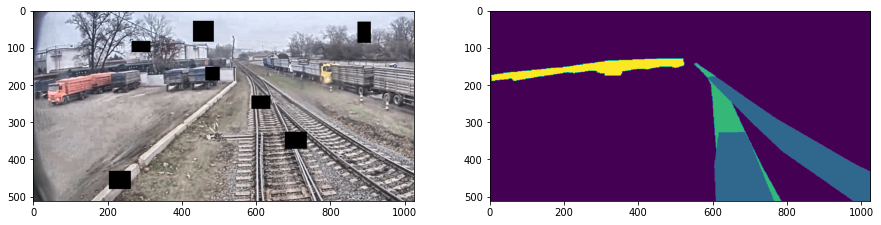

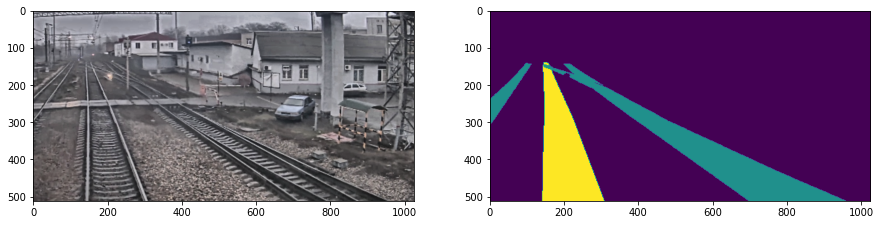

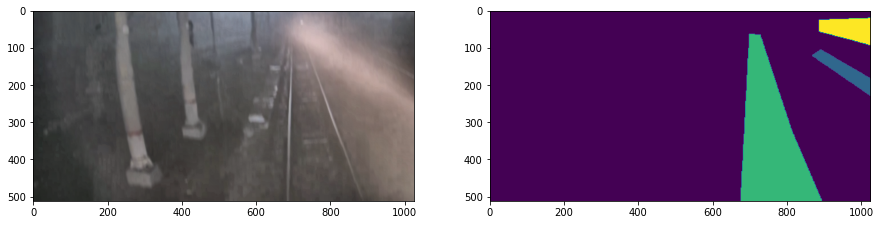

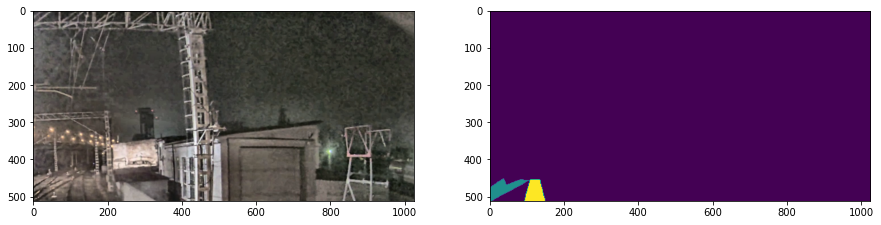

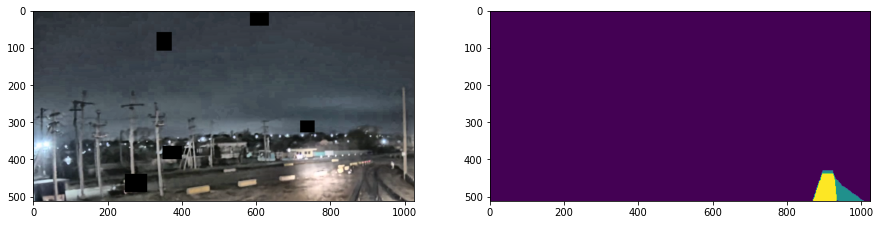

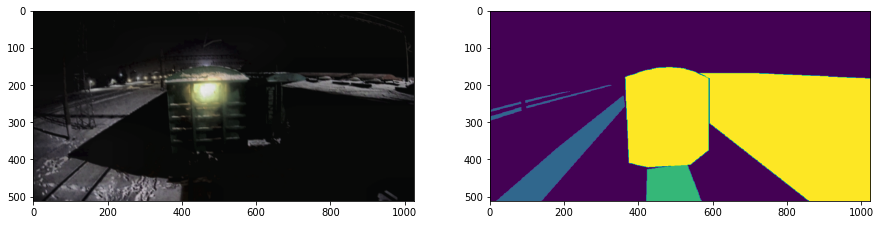

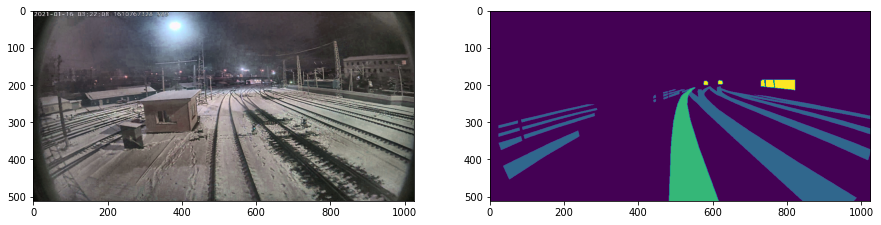

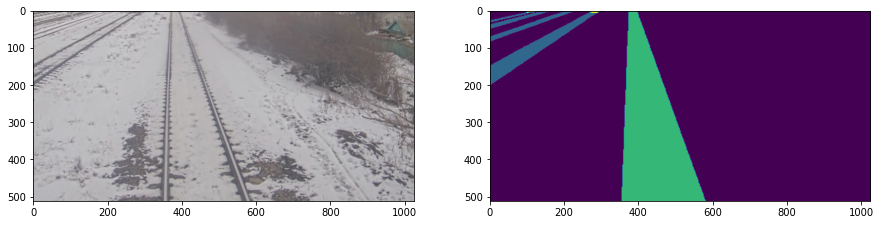

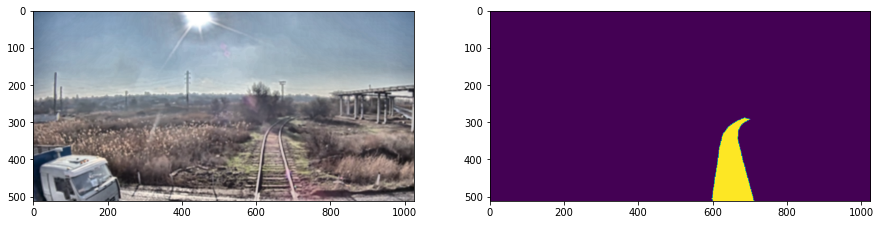

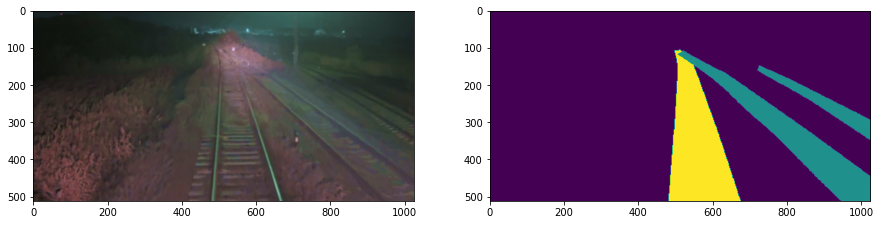

In [22]:
#Визуализация батча

plt.rcParams["figure.figsize"] = (15,15)

for image, segmentation in zip(image_batch[10:20], segmentation_batch[10:20]):

    image = np.moveaxis(image.numpy()*255, 0, -1).astype(int)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(segmentation)
    plt.show()

In [12]:
#Загрузка модели

# model = smp.Unet('resnext50_32x4d', encoder_weights='imagenet', classes=4, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
model = smp.Unet('resnet34', encoder_weights='imagenet', classes=4, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [13]:
#Целевая метрика

miou_metric = smp.utils.metrics.IoU(threshold=0.5)

In [14]:
#Трейн луп

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler):
    torch.cuda.empty_cache()
    iou_min = 0
    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        train_loss = 0
        iou_score = 0
        model.train()
        for i, batch in enumerate(tqdm(train_loader)):
    
            image, mask, multy_mask = batch['image'], batch['single_mask'], batch['multy_mask']
            
            image = image.to(device); mask = mask.to(device); multy_mask = multy_mask.to(device)
            output = model(image)
            loss = criterion(output, mask.long())

            iou_score += miou_metric(output[:, 1:, :, :], multy_mask[:, 1:, :, :]).cpu().detach().numpy()
        
            loss.backward()
            optimizer.step()          
            optimizer.zero_grad()
            scheduler.step() 
            train_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            val_iou_score = 0
            with torch.no_grad():
                for i, batch in enumerate(tqdm(val_loader)):
                    image, mask, multy_mask = batch['image'], batch['single_mask'], batch['multy_mask']
            
                    image = image.to(device); mask = mask.to(device); multy_mask = multy_mask.to(device)
                    
                    output = model(image)                

                    val_iou_score += miou_metric(output[:, 1:, :, :], multy_mask[:, 1:, :, :]).cpu().detach().numpy()
                    loss = criterion(output, mask.long())                                 
                    test_loss += loss.item()
            
            if iou_min < (val_iou_score/len(val_loader)):
                print('iou increasing.. {:.3f} >> {:.3f} '.format(iou_min, (val_iou_score/len(val_loader))))
                iou_min = (val_iou_score/len(val_loader))
                print('saving model...')
                torch.save(model, f'../models/{GLOBAL_PARAMETERS["MODEL_NAME"]}')
            
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(train_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    torch.save(model, f'../models/last_{GLOBAL_PARAMETERS["MODEL_NAME"]}')

In [ ]:
import time

device = 'cuda:0'

max_lr = 1e-3
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=GLOBAL_PARAMETERS['NUM_EPOCHS'],
                                            steps_per_epoch=len(train_loader), pct_start=0.1)

fit(GLOBAL_PARAMETERS['NUM_EPOCHS'], model, train_loader, val_loader, criterion, optimizer, sched)

In [ ]:
#Лоадер для холдаута

holdt_ds = NiiasDataset(
        df=holdt_df,
        transform=val_transforms)

holdt_loader = DataLoader(
    holdt_ds,
    batch_size=1,
    num_workers=1,
    shuffle=False,
)

In [ ]:
#Загрузка модели и подсчет метрики

model = torch.load(f'../models/{GLOBAL_PARAMETERS["MODEL_NAME"]}', map_location=device)

model.eval()
holdt_iou_score = 0
with torch.no_grad():
    for n, batch in enumerate(tqdm(holdt_loader)):
        image, mask, multy_mask = batch['image'], batch['single_mask'], batch['multy_mask']
            
        image = image.to(device); mask = mask.to(device); multy_mask = multy_mask.to(device)
        output = model(image)
        
        holdt_iou_score += miou_metric(output[:, 1:, :, :], multy_mask[:, 1:, :, :]).cpu().detach().numpy()
            
holdt_iou_score/len(holdt_loader)